In [1]:
cd C:\Users\IITM\Downloads

C:\Users\IITM\Downloads


In [2]:

import os
import harp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
from cmcrameri import cm
import requests
import sentinelsat
import shutil
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patheffects as path_effects

In [24]:
filename = "S5P_RPRO_L2__AER_LH_20220114T014420_20220114T032550_22043_03_020400_20221126T215002.nc"
aer_layer = harp.import_product(filename)
print(aer_layer)

source product = 'S5P_RPRO_L2__AER_LH_20220114T014420_20220114T032550_22043_03_020400_20221126T215002.nc'

int scan_subindex {time=1869504}
double datetime_start {time=1869504} [seconds since 2010-01-01]
float datetime_length [s]
long orbit_index
long validity {time=1869504}
float latitude {time=1869504} [degree_north]
float longitude {time=1869504} [degree_east]
float latitude_bounds {time=1869504, 4} [degree_north]
float longitude_bounds {time=1869504, 4} [degree_east]
float sensor_latitude {time=1869504} [degree_north]
float sensor_longitude {time=1869504} [degree_east]
float sensor_altitude {time=1869504} [m]
float solar_zenith_angle {time=1869504} [degree]
float solar_azimuth_angle {time=1869504} [degree]
float sensor_zenith_angle {time=1869504} [degree]
float sensor_azimuth_angle {time=1869504} [degree]
float surface_altitude {time=1869504} [m]
float surface_altitude_uncertainty {time=1869504} [m]
float surface_pressure {time=1869504} [Pa]
float surface_meridional_wind_velocity {

In [ ]:
operations = ";".join([
    "aerosol_height>0.50",
    "keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,aerosol_height)",
    "derive(datetime_stop {time} [days since 2000-01-01])",
    "derive(datetime_start [days since 2000-01-01])",
    "exclude(datetime_length)",
    "bin_spatial(721,-90,0.25,1441,-180,0.25)", # lat_cells, corner_lat, lat_resolution, lon_cells, corner_lon, lon_resolution, 
    "derive(aerosol_height)",
    "derive(latitude {latitude})",
    "derive(longitude {longitude})",
])

In [ ]:
reduce_operations = "squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()"

In [ ]:
filenames = r"S5P_RPRO_L2__AER_LH_20220114T*.nc"

In [ ]:
merged = harp.import_product(filenames, operations, reduce_operations=reduce_operations)
print(merged)

In [ ]:
gridlat = np.append(merged.latitude_bounds.data[:,0], merged.latitude_bounds.data[-1,1])
gridlon = np.append(merged.longitude_bounds.data[:,0], merged.longitude_bounds.data[-1,1])

In [ ]:
aer_l = merged.aerosol_height.data
aer_l_units = merged.aerosol_height.unit
aer_l_description = merged.aerosol_height.description

colortable=cm.batlow
# For Dobson Units
vmin=0
vmax=1

In [ ]:
aa = np.arange(14,32)
print(aa)

In [ ]:
data_f = []
for i in aa:
    filenames = r"S5P_RPRO_L2__AER_LH_202201"+str(i)+"T*.nc"
    merged = harp.import_product(filenames, operations, reduce_operations=reduce_operations)
    data_f.append(merged.aerosol_height.data[0,:,:])
    merged = None

In [ ]:
days = pd.date_range(start='01/14/2022', end='01/31/2022')
days

In [ ]:
lon = np.arange(-180,180,0.25)
lat = np.arange(-90,90,0.25)

In [ ]:
import xarray as xr

trop_aer_layer = xr.Dataset(
    data_vars={"aerosol_height": (("days","lat","lon",),np.array(data_f))
              },
    coords = {"lat":(("lat"),lat,),
              "lon":(("lon"),lon),
              "days":(("days"),days),
              "gridlon":(("gridlon"),gridlon),
              "gridlat":(("gridlat"),gridlat)
             },
            
    
    attrs={'Long_name':'Aerosol Height ',
           'units':'m',
           'title': 'Copernicus Sentinel 5P TROPOMI aerosol_height ',
           'dimensions(sizes)': 'lon(1440), lat(720), time(18))',
           'web-site1':'http://www.tropomi.eu/data-products/level-2-products',
           'web-site2':'https://data-portal.s5p-pal.com/product-docs/no2/PAL_reprocessing_NO2_v02.03.01_20211215.pdf',
           'Instruction':'Kindly use "gridlon" and "gridlat" variable in plotting "pcolormesh"',
           'Author and mail':'K. Madan Mohan Rao and kmmraoiitm@gmail.com'
          })

In [ ]:
trop_aer_layer.to_netcdf('S5P_TROPOMI_aer_layer_Jenny.nc',format='NETCDF4')

## Plotting

In [4]:
import xarray as xr
ds = xr.load_dataset('S5P_TROPOMI_aer_layer_Jenny.nc')
ds

<xarray.Dataset>
Dimensions:         (days: 18, lat: 720, lon: 1440, gridlon: 1441, gridlat: 721)
Coordinates:
  * lat             (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
  * lon             (lon) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * days            (days) datetime64[ns] 2022-01-14 2022-01-15 ... 2022-01-31
  * gridlon         (gridlon) float64 -180.0 -179.8 -179.5 ... 179.5 179.8 180.0
  * gridlat         (gridlat) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
Data variables:
    aerosol_height  (days, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Long_name:          Aerosol Height 
    units:              m
    title:              Copernicus Sentinel 5P TROPOMI aerosol_height 
    dimensions(sizes):  lon(1440), lat(720), time(18))
    web-site1:          http://www.tropomi.eu/data-products/level-2-products
    web-site2:          https://data-portal.s5p-pal.com/product-docs/no2/PAL_...
    Instruction:        Kindly use "gridlon" and "gridlat" variable in plotti...
    Author and mail:    K. Madan Mohan Rao and kmmraoiitm@gmail.com

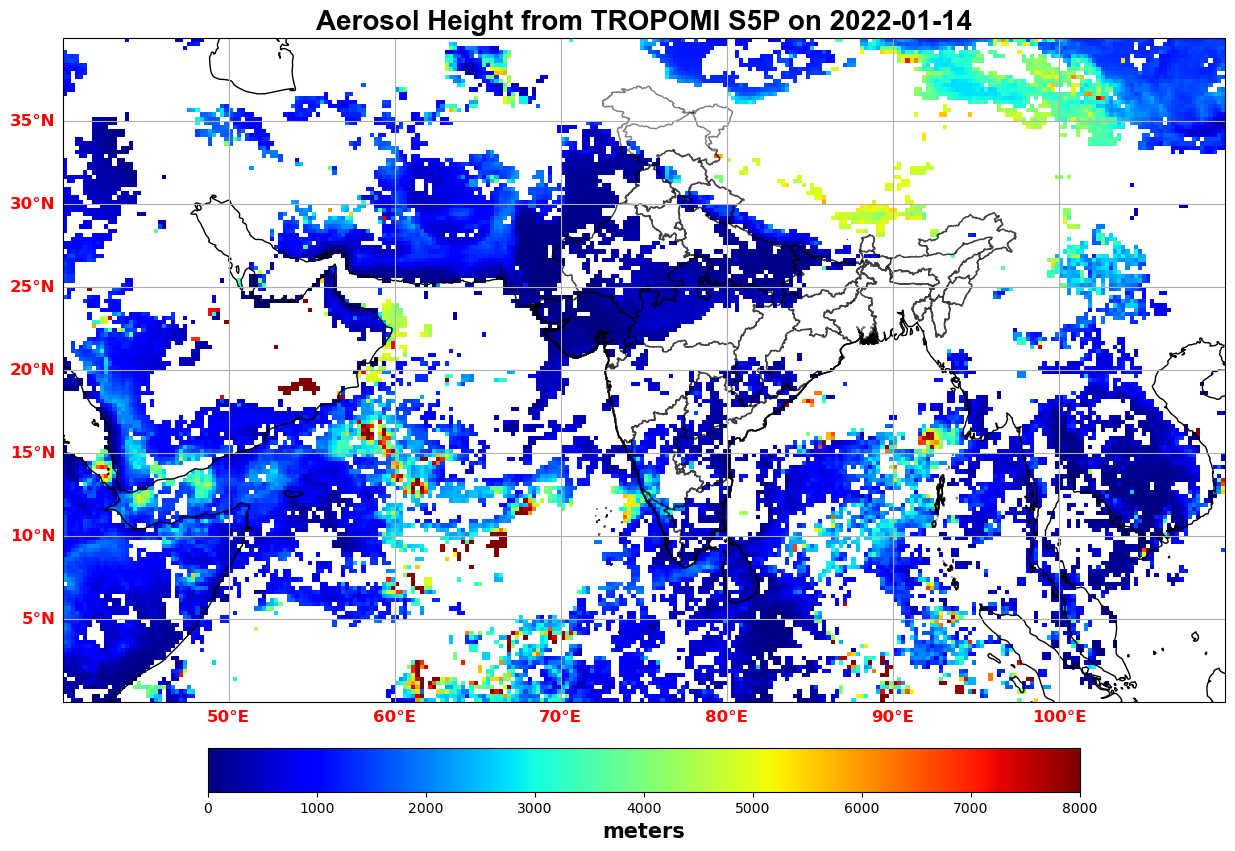

In [32]:
fname= r'F:\Indian Shape Files\Indian Administrative bourders\IND_adm\IND_adm1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())
fname2 = r'F:\Indian Shape Files\Only Indian Boundaries\India_Boundary\India_Boundary.shp'
adm1_shapes2 = list(shpreader.Reader(fname2).geometries())
# fname3 = r'D:\Clip-data-from-netCDF-file-and-plot-using-Cartopy-main\Dharashiv.shp'
# adm1_shapes3 = list(shpreader.Reader(fname3).geometries())

m=0
def main():
    plt.figure(figsize=(15,12),facecolor = 'white')
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([40,110,0,40], crs=ccrs.PlateCarree()) # [lonmin,lonmax,latmin,latmax]
    ax.coastlines()
    ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.5,lw = 1, facecolor='none') #
    ax.add_geometries(adm1_shapes2, ccrs.PlateCarree(),
                  edgecolor='black', alpha=0.5,lw = 1, facecolor='none') #
#     ax.add_geometries(adm1_shapes3, ccrs.PlateCarree(),
#                   edgecolor='red', alpha=0.5,lw = 2, facecolor='none') #
#     ax.add_feature(cfeature.LAND, edgecolor='black')
#     ax.add_feature(cfeature.BORDERS,lw = 2,edgecolor='red')
#     ax.add_feature(cfeature.STATES.with_scale('10m'),
#                linestyle='-', alpha=.25, facecolor='none',lw = 2, edgecolor='red')
    
#     ax.add_feature(cfeature.COASTLINE)
#     ax.gridlines()
    ax.set_facecolor('white')
    ax.set_title('Aerosol Height from TROPOMI S5P on '+str(ds.days[m])[36:46],fontweight="bold", size=20,family= 'Arial')
    filled_c = plt.pcolormesh(ds.gridlon, ds.gridlat, ds.aerosol_height[m,:,:], 
                              vmin=0, vmax=8000, cmap='jet', transform=ccrs.PlateCarree())
#     filled_c = plt.imshow( SO2val[0,:,:], vmin=vmin, vmax=vmax, cmap='inferno', transform=ccrs.PlateCarree())
#     ax.plot(lon23102022,lat23102022,markersize=10,marker='^',color='yellow',lw=4,label='23102022')
#     ax.plot(lon24102022,lat24102022,markersize=10,marker='^',color='lime',lw=4,label='24102022')
#     plt.text(76.0420,18.4,'Osmanabad Airport',horizontalalignment='right', color= 'red',fontweight="bold", size=20,family= 'Arial')
#     ax.legend()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(40,110,10))
    gl.ylocator = mticker.FixedLocator(np.arange(0,40,5))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12,'color': 'red', 'weight': 'bold'}
    gl.ylabel_style = {'size': 12,'color': 'red', 'weight': 'bold'}
        # Add a colorbar for the filled contour.
    a = plt.colorbar(filled_c,ax=ax, orientation='horizontal',pad=0.05,shrink=0.75)
    a.set_label(label=f'meters',weight='bold', fontsize='15')
#     plt.figtext(0.25, 0.085, "\xa9 kmmraoiitm@gmail.com", ha="center", 
#                 fontsize=15)#box={"facecolor": "green", "alpha": 0.75})

if __name__ == '__main__':
    main()
plt.savefig('Aer_hight_TROPOMI_S5P_on_f'+str(ds.days[m])[36:46]+'.jpg',bbox_inches='tight',dpi=720)
plt.show()